# 第6章:機械学習

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2022-05-12 23:26:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  26.7MB/s    in 1.0s    

2022-05-12 23:26:05 (26.7 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


## 50.データの入手・整形
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 読み込み
df = pd.read_csv('./newsCorpora.csv', header=None, sep='\t', names=['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp'])

# 抽出
df = df.loc[df['publisher'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['title', 'category']]

# 分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=0, stratify=df['category'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=0, stratify=valid_test['category'])

# 保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 確認
print('【学習データ】')
print(train['category'].value_counts())
print('【検証データ】')
print(valid['category'].value_counts())
print('【評価データ】')
print(test['category'].value_counts())

【学習データ】
b    4502
e    4223
t    1219
m     728
Name: category, dtype: int64
【検証データ】
b    562
e    528
t    153
m     91
Name: category, dtype: int64
【評価データ】
b    563
e    528
t    152
m     91
Name: category, dtype: int64


In [29]:
train 

,title,category
276134,fitch lower south africa credit rating outlook...,b
382850,forex dollar rise on us rate speculation after...,b
370769,update 0 mexico s low house generally approve ...,b
12938,u s navy seal take control of north korean fla...,b
318782,beyonce beyonce jay z pay tribute michael jack...,e
...,...,...
175007,fashion designer dolce gabbana lose appeal of ...,e
192346,update 0 draghi say ecb poise shore up economy...,b
4495,bank austria may sell ukraine unit within year...,b
168520,voice s blake shelton share adam levine s real...,e


## 51.特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

### 特徴量設計
1. 各文章をNLTKで形態素解析する。
2. そのうち、文の意味に強く関わるような品詞（名詞、形容詞、副詞、疑問詞等）だけを残した文字列を作成する。
3. それらの文字列からbi-gramのTF-idfを計算し、各文章中の各単語のTF-IDFの値を特徴量とする


[NLTKtag](https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk)

In [5]:
from nltk import *

download('punkt')
download('wordnet')
download('averaged_perceptron_tagger')
stemmer = stem.PorterStemmer()
lemmatizer = stem.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [6]:
import re

# 文字列の前処理
def char_processing(text):
    text = re.sub(r'[^\w\s]', ' ', text) # スペース以外の記号文字全てをスペースに置換
    text = re.sub(r'\s{2,}', ' ', text) # ２個以上のスペースは一つに置換
    text = text.lower() # 小文字化
    text = re.sub('[0-9]+', '0', text)  # 数字列を0に置換
    return text

# 各単語の見出し語を返す
def lemma(word, pos):
    if pos.startswith('J'): # 形容詞
        return lemmatizer.lemmatize(word, pos="a")
    elif pos.startswith('V'): # 動詞
        return lemmatizer.lemmatize(word, pos="v")
    elif pos.startswith('N'): # 名詞
        return lemmatizer.lemmatize(word, pos="n")
    elif pos.startswith('R'): # 副詞
        return lemmatizer.lemmatize(word, pos="r")
    else:
        return word

# 文章を形態素解析を行い、以下の品詞だけを残した文字列に変換する
# CD 基数, FW 外国語, IN 前置詞または従属接続詞
# JJ 形容詞, JJR 形容詞 (比較級), JJS 形容詞 (最上級), MD 法
# NN 名詞, NNS 名詞 (複数形), NNP 固有名詞, NNPS 固有名詞 (複数形)
# PDT 前限定辞, POS 所有格の終わり, PRP 人称代名詞 (PP), PRP 	所有代名詞 (PP$)
# RB 副詞, RBR 副詞 (比較級), RBS 副詞 (最上級), RP 不変化詞, UH  感嘆詞
# VB 動詞 (原形), VBD 動詞 (過去形), VBG 動詞 (動名詞または現在分詞), VBN 動詞 (過去分詞), VBP 動詞 (三人称単数以外の現在形), VBZ 動詞 (三人称単数の現在形)
# WDT Wh 限定詞, WP Wh 代名詞, WP$ 所有 Wh 代名詞, WRB Wh 副詞
def lemma_and_pos_extract(text):
    tokens = word_tokenize(text) # 分かち書き
    tokens = [lemma(word,pos) for word, pos in pos_tag(tokens) if pos in ('CD','FW','IN', 'JJ','JJR', 'JJS','MD', 'NN', 'NNP', 'NNS', 'PDT', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$','WRB')] # 品詞列
    text = ' '.join(tokens) # token配列を文章に戻す
    return text

# dfのtitleを重要な品詞だけを残した文字列に変換する
def preprocessing(train, valid, test):
    train['title'] = train['title'].map(lambda x: lemma_and_pos_extract(char_processing(x)))
    valid['title'] = valid['title'].map(lambda x: lemma_and_pos_extract(char_processing(x)))
    test['title'] = test['title'].map(lambda x: lemma_and_pos_extract(char_processing(x)))
    return train, valid, test

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 前処理
train, valid, test = preprocessing(train, valid, test)

# TfidfVectorizer
tfidf_vec = TfidfVectorizer(min_df=10, ngram_range=(1, 2))  # bi-gramまでを考慮する

# ベクトル化
train_vec = tfidf_vec.fit_transform(train['title']) 
valid_vec = tfidf_vec.transform(valid['title']) 
test_vec = tfidf_vec.transform(test['title']) 

# データフレームに変換
x_train = pd.DataFrame(train_vec.toarray(), columns=tfidf_vec.get_feature_names())
x_valid = pd.DataFrame(valid_vec.toarray(), columns=tfidf_vec.get_feature_names())
x_test = pd.DataFrame(test_vec.toarray(), columns=tfidf_vec.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
x_train

,0m,0nd,0s,0st,0th,0th birthday,aa,abbvie,abc,about,...,your,your mother,yr,yr high,yuan,zac,zac efron,zendaya,zone,zone bond
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# データの保存
x_train.to_csv('./train.feature.txt', index=False)
x_valid.to_csv('./valid.feature.txt', index=False)
x_test.to_csv('./test.feature.txt', index=False)

In [8]:
# 正解値
y_train = train['category']
y_valid = valid['category']
y_test = test['category']

## 52.学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [9]:
from sklearn.linear_model import LogisticRegression
# 学習
lg = LogisticRegression(random_state=0, max_iter=10000)
lg.fit(x_train, y_train)

LogisticRegression(max_iter=10000, random_state=0)

## 53.予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [20]:
import numpy as np
def pred_category(lg, data):
    Pred = lg.predict(data) # 予測値
    Prob = np.max(lg.predict_proba(data), axis=1) # 確率
    return pd.DataFrame([Pred,Prob], index=['Pred', 'Prob']).T
train_pred = pred_category(lg,x_train)
test_pred = pred_category(lg,x_test)
test_pred

,Pred,Prob
0,t,0.690679
1,e,0.493982
2,b,0.931382
3,b,0.916632
4,e,0.567933
...,...,...
1329,b,0.946871
1330,e,0.920244
1331,e,0.777
1332,e,0.849184


## 54.正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ

In [22]:
from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(y_train, train_pred['Pred'])
test_accuracy = accuracy_score(y_test, test_pred['Pred'])
print(f'正解率（train）：{train_accuracy:.3f}')
print(f'正解率（test）：{test_accuracy:.3f}')

正解率（train）：0.925
正解率（test）：0.895


## 55.混合行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

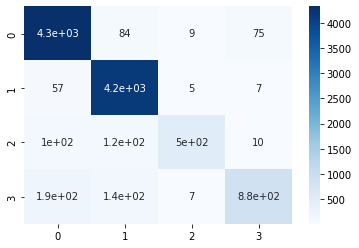

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 学習データ
train_cm = confusion_matrix(y_train, train_pred['Pred'])
sns.heatmap(train_cm, annot=True, cmap='Blues')
plt.show()

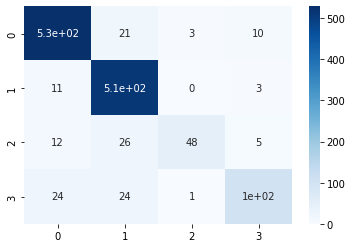

In [24]:
# 評価データ
test_cm = confusion_matrix(y_test, test_pred['Pred'])
sns.heatmap(test_cm, annot=True, cmap='Blues')
plt.show()

## 56.適合率・再現率・F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．


**適合率(accuracy)**：システムの精度、正解率、「正確性の指標」

**再現率(recall)**：正であるものをどれだけ回収(予測)できたかの割合、「網羅性の指標」

**F値**：適合率と再現率の調和平均、適合率と再現率という2つの効率でこなす場合の平均効率

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
# 適合率
precision = list(precision_score(y_test, test_pred['Pred'], average=None, labels=['b', 'e', 't', 'm']))
precision.append(precision_score(y_test, test_pred['Pred'], average='micro'))
precision.append(precision_score(y_test, test_pred['Pred'], average='macro'))

# 再現率
recall = list(recall_score(y_test, test_pred['Pred'], average=None, labels=['b', 'e', 't', 'm']))
recall.append(recall_score(y_test, test_pred['Pred'], average='micro'))
recall.append(recall_score(y_test, test_pred['Pred'], average='macro'))

# F値
f1 = list(f1_score(y_test, test_pred['Pred'], average=None, labels=['b', 'e', 't', 'm']))
f1.append(f1_score(y_test, test_pred['Pred'], average='micro'))
f1.append(f1_score(y_test, test_pred['Pred'], average='macro'))

pd.DataFrame({'適合率': precision, '再現率': recall, 'F1スコア': f1},
                        index=['b', 'e', 't', 'm', 'マイクロ平均', 'マクロ平均'])

,適合率,再現率,F1スコア
b,0.918403,0.939609,0.928885
e,0.878632,0.973485,0.923630
t,0.851240,0.677632,0.754579
m,0.923077,0.527473,0.671329
マイクロ平均,0.895052,0.895052,0.895052
マクロ平均,0.892838,0.779550,0.819606


## 57.特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [26]:
for category, coef in zip(lg.classes_, lg.coef_):
  print(f'【カテゴリ{category}】')
  features = pd.DataFrame([x_train.columns.values, coef]).T.set_axis(['feature','coef'], axis=1).sort_values(by='coef')
  best10 = features.tail(10)['feature'][::-1].reset_index(drop=True)
  worst10 = features.head(10)['feature'].reset_index(drop=True)
  display(pd.DataFrame([best10, worst10], index=['TOP10', 'WORST10']))
  print('\n')

【カテゴリb】


,0,1,2,3,4,5,6,7,8,9
TOP10,bank,china,stock,ecb,fed,ukraine,euro,yellen,obamacare,oil
WORST10,her,video,ebola,aereo,star,apple,she,child,virus,microsoft




【カテゴリe】


,0,1,2,3,4,5,6,7,8,9
TOP10,kardashian,chris,star,film,movie,he,beyonce,jay,fan,trailer
WORST10,update,us,google,study,china,say,gm,billion,ceo,facebook




【カテゴリm】


,0,1,2,3,4,5,6,7,8,9
TOP10,ebola,study,drug,cigarette,fda,cancer,mers,could,outbreak,medical
WORST10,gm,facebook,big,deal,apple,google,bank,ceo,climate,twitter




【カテゴリt】


,0,1,2,3,4,5,6,7,8,9
TOP10,google,facebook,apple,microsoft,climate,gm,tesla,nasa,earth,heartbleed
WORST10,drug,her,rate,percent,cancer,still,heart,food,ukraine,ecb


## 58.正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

**penalty**	正則化の方法を指定するパラメータ。'l1'か'l2'を指定する。'l1'を指定した場合はL1正則化、'l2'を指定した場合はL2正則化を行う（デフォルト値は'l2'）。L1正則化は多くの説明変数の重みが0になるようにし、特徴選択の手法としても使用される。L2正則化は説明変数の重みが大きくなりすぎるのを防ぎ、過学習を回避するために利用される。

**C**	正則化の強さを指定するパラメータ。正の値を指定する（デフォルト値は1.0）。Cの値が小さいほど正則化の強さが増す。

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [27]:
from sklearn.metrics import accuracy_score
result = []
for C in np.logspace(-5, 5, 11):
    # 学習
    lg = LogisticRegression(random_state=0, max_iter=10000, C=C)
    lg.fit(x_train, y_train)
    # 予測値
    train_pred = lg.predict(x_train)
    valid_pred = lg.predict(x_valid)
    test_pred = lg.predict(x_test)
    # 正解率
    train_accuracy = accuracy_score(y_train, train_pred)
    valid_accuracy = accuracy_score(y_valid, valid_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    # 保存
    result.append([C, train_accuracy, valid_accuracy, test_accuracy])

In [28]:
result_df = pd.DataFrame(result, columns=['C', 'train', 'valid', 'test'])
result_df

,C,train,valid,test
0,0.00001,0.421852,0.421289,0.422039
1,0.00010,0.421852,0.421289,0.422039
2,0.00100,0.456522,0.458021,0.459520
3,0.01000,0.769959,0.764618,0.770615
4,0.10000,0.810439,0.795352,0.810345
5,1.00000,0.924756,0.885307,0.895052
6,10.00000,0.974888,0.889055,0.897301
7,100.00000,0.994378,0.871814,0.890555
8,1000.00000,0.998688,0.862069,0.874813
9,10000.00000,0.998688,0.852324,0.862069


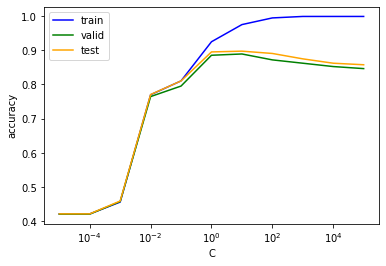

In [29]:
result_df = pd.DataFrame(result, columns=['C', 'train', 'valid', 'test'])

plt.plot(result_df['C'], result_df['train'], label='train', c='blue')
plt.plot(result_df['C'], result_df['valid'], label='valid', c='green')
plt.plot(result_df['C'], result_df['test'], label='test', c='orange')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('accuracy')
plt.legend(loc=0) 
plt.show()

## 59.ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

### ランダムフォレスト

**min_samples_split(default=2)**
中間ノードに属するサンプル数がこの数字未満になったら、分割ストップする.


In [33]:
from sklearn.ensemble import RandomForestClassifier
RFCresult = []
for min_sample in [2]+list(range(10, 110, 10)):
    # 学習
    RFC = RandomForestClassifier(random_state=0, min_samples_split=min_sample)
    RFC.fit(x_train, y_train)
    # 予測値
    train_pred = RFC.predict(x_train)
    valid_pred = RFC.predict(x_valid)
    test_pred = RFC.predict(x_test)
    # 正解率
    train_accuracy = accuracy_score(y_train, train_pred)
    valid_accuracy = accuracy_score(y_valid, valid_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    # 保存
    RFCresult.append([min_sample, train_accuracy, valid_accuracy, test_accuracy])

In [34]:
RFCresult_df = pd.DataFrame(RFCresult, columns=['min_sample', 'train', 'valid', 'test'])
RFCresult_df

,min_sample,train,valid,test
0,2,0.998876,0.851574,0.856822
1,10,0.990349,0.846327,0.857571
2,20,0.978542,0.846327,0.856822
3,30,0.968141,0.844078,0.855322
4,40,0.959052,0.840330,0.850075
5,50,0.953430,0.843328,0.854573
6,60,0.948463,0.839580,0.855322
7,70,0.944340,0.839580,0.856072
8,80,0.940780,0.837331,0.851574
9,90,0.936938,0.835832,0.852324


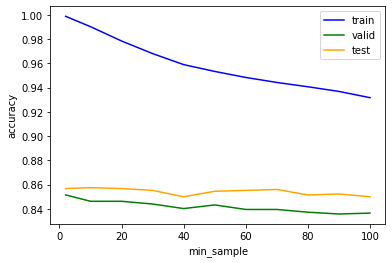

In [35]:
plt.plot(RFCresult_df['min_sample'], RFCresult_df['train'], label='train', c='blue')
plt.plot(RFCresult_df['min_sample'], RFCresult_df['valid'], label='valid', c='green')
plt.plot(RFCresult_df['min_sample'], RFCresult_df['test'], label='test', c='orange')
plt.xlabel('min_sample')
plt.ylabel('accuracy')
plt.legend(loc=0) 
plt.show()

### XGboost

In [43]:
import xgboost as xgb
from tqdm import tqdm
# XGBoost用にフォーマット変換
category_dict = {'b': 0, 'e': 1, 't':2, 'm':3}
y_train_int = train['category'].map(lambda x: category_dict[x])
y_valid_int = valid['category'].map(lambda x: category_dict[x])
y_test_int = test['category'].map(lambda x: category_dict[x])
XGBresult = []
for eta in tqdm(np.logspace(-5, 0, 6)):
    params={'objective': 'multi:softmax', 
        'num_class': 4,
        'eval_metric': 'mlogloss',
        'eta':eta,
        'max_depth': 5
        }

    dtrain = xgb.DMatrix(x_train, label=y_train_int)
    dvalid = xgb.DMatrix(x_valid, label=y_valid_int)
    dtest = xgb.DMatrix(x_test, label=y_test_int)
    # モデルの学習
    watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(params, dtrain, num_boost_round=500, evals=watchlist, early_stopping_rounds=10,verbose_eval=0 )

    # 予測値の取得
    train_pred = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    valid_pred = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    test_pred = model.predict(dtest, ntree_limit=model.best_ntree_limit)

    # 正解率
    train_accuracy = accuracy_score(y_train_int, train_pred) 
    valid_accuracy = accuracy_score(y_valid_int, valid_pred) 
    test_accuracy = accuracy_score(y_test_int, test_pred) 

    # 保存
    XGBresult.append([eta, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 6/6 [1:45:45<00:00, 1057.52s/it]


In [44]:
XGBresult_df = pd.DataFrame(XGBresult, columns=['eta', 'train', 'valid', 'test'])
XGBresult_df

,eta,train,valid,test
0,0.00001,0.621533,0.632684,0.629685
1,0.00010,0.621064,0.633433,0.629685
2,0.00100,0.668666,0.679910,0.683658
3,0.01000,0.769490,0.756372,0.765367
4,0.10000,0.925975,0.862069,0.871814
5,1.00000,0.991754,0.880810,0.893553


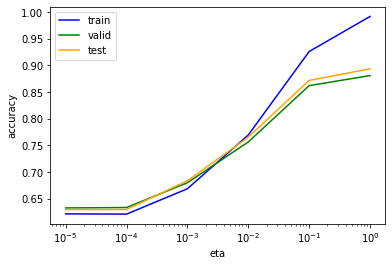

In [45]:
plt.plot(XGBresult_df['eta'], XGBresult_df['train'], label='train', c='blue')
plt.plot(XGBresult_df['eta'], XGBresult_df['valid'], label='valid', c='green')
plt.plot(XGBresult_df['eta'], XGBresult_df['test'], label='test', c='orange')
plt.xscale('log')
plt.xlabel('eta')
plt.ylabel('accuracy')
plt.legend(loc=0) 
plt.show()

### AutoML
参考: [テーブルデータの分類問題における AutoML 入門](https://ai.access-company.com/586/)

以下を自動化する

* データの前処理、クリーニング
* 適切な特徴量の選択と作成（特徴量エンジニアリング）
* モデルの学習
* ハイパーパラメータ最適化
* モデルの学習- ハイパーパラメータ最適化
* モデルの性能評価と最適なモデルの選択
* モデルのアンサンブル

In [6]:
# https://automl.github.io/auto-sklearn/master/installation.html
# install all dependencies manually
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip -q install
!pip install -q auto-sklearn

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   259  100   259    0     0   3363      0 --:--:-- --:--:-- --:--:--  3363


Build and Fit a Classifier

In [7]:
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import plot_partial_dependence, permutation_importance

from smac.tae import StatusType
import autosklearn
import autosklearn.classification
import autosklearn.metrics

アンサンブル
アンサンブルとは、複数のモデルを組み合わせてモデルを作ること、もしくは予測を行う方法です。アンサンブルによって、モデル性能の向上が見込まれます。一方で複数のモデルを利用するため、単一のモデルのみ利用する場合に比べて、計算コストが高くなるデメリットもあります。シンプルなアンサンブルの方法としては、複数のモデルの予測値の平均をとる方法が挙げられます。

In [12]:
%%time
model = autosklearn.classification.AutoSklearnClassifier(
    metric=autosklearn.metrics.accuracy, # 評価関数
    time_left_for_this_task=3600,  # 全体の実行時間　in sec
    per_run_time_limit=600,  # 1つのモデルにかける限界探索時間 in sec
    memory_limit=3072,  # メモリ空間 in MB
    resampling_strategy='holdout',
    resampling_strategy_arguments={'train_size': 0.67},
    n_jobs=1,
    seed=2,
    ensemble_size=50,
    # delete_tmp_folder_after_terminate=False,
    # tmp_folder="./autosklearn_tmp"
)
# X_test, y_test will be used to save test predictions for all models. This allows to evaluate the performance of Auto-sklearn over time.
model.fit(x_train, y_train, x_valid, y_valid)
# model.fit(X_train, y_train, dataset_name='titanic_example')

CPU times: user 20.6 s, sys: 12.6 s, total: 33.2 s
Wall time: 59min 57s


In [13]:
# y_train_pred = model.predict(X_train)
# print("Accuracy score", sklearn.metrics.accuracy_score(y_train, y_train_pred))
s = model.score(x_train, y_train)
print(f"Train score {s}")

Train score 0.9548350824587706


In [16]:
# save and load model
import pickle

dump_file = "model.pickle"

with open(dump_file, 'wb') as f:
    pickle.dump(model, f)

with open(dump_file, 'rb') as f:
    restored_model = pickle.load(f)

In [17]:
#  the statistics of the training result:
print(model.sprint_statistics())

auto-sklearn results:
  Dataset name: 6328e992-d1e3-11ec-8745-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.844691
  Number of target algorithm runs: 24
  Number of successful target algorithm runs: 13
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 8




Predict and Evaluate the Final Ensemble

In [18]:
# y_pred = model.predict(X_test)
# print("Accuracy score", sklearn.metrics.accuracy_score(y_test, y_pred))
s = model.score(x_test, y_test)
print(f"Test score {s}")

Test score 0.8845577211394303


The Best Single Model

In [19]:
model.leaderboard(detailed=False, ensemble_only=True, sort_by='cost')

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
2,1,0.14,random_forest,0.155309,88.115092
11,2,0.18,gradient_boosting,0.158149,231.755100
20,3,0.20,extra_trees,0.159001,38.298950
22,4,0.14,mlp,0.201306,346.105440
7,5,0.12,gradient_boosting,0.224304,127.278958
24,6,0.04,mlp,0.250710,50.614730
6,7,0.08,gradient_boosting,0.257808,339.250388
15,8,0.08,k_nearest_neighbors,0.361442,33.407133
23,9,0.02,libsvm_svc,0.362294,417.564768
